In [6]:
import scipy.stats as ss
import pandas as pd
data = pd.read_csv('df_with_tp_classifications.csv')

The Mann-Whitney test is a non-parametric test for a difference in distribution between two datasets.

In [9]:
data_tp = data.loc[data.TP]
data_fp = data.loc[~data.TP]
print('TP: ', len(data_tp), 'FP: ', len(data_fp))

TP:  84 FP:  348


This initial dataset contains 84 identified true positives and 348 false positives. We are testing 8 variables as candidate parameters for a filter function. A prerequisite for use in the filter is that there is a difference in the distribution of the variable between true positive and false positives. If not, it isn't much use in a filter. We use a conservative adjustment for multiple hypothesis testing by dividing the threshold p-value by the number of variables being tested. 

In [41]:
variables = ['circularity', 'solidity',
             'tc_channel0', 'tc_channel1', 'tc_channel2',
             'fc_channel0', 'fc_channel1', 'fc_channel2']
p_threshold = 0.05/len(variables)

In [42]:
results = {}
for var in variables:
    results[var] = {}
    u, p = ss.mannwhitneyu(data_tp[var], data_fp[var])
    results[var]['u'] = u
    results[var]['p'] = p
    results[var]['sig'] = p < p_threshold
    results[var]['del_median'] = data_tp[var].median() - data_fp[var].median()


In [43]:
results = pd.DataFrame(results).T
results

,u,p,sig,del_median
circularity,20731.5,0.0,True,0.145506
solidity,21438.0,0.0,True,0.043613
tc_channel0,20157.0,0.0,True,15.038399
tc_channel1,20577.0,0.0,True,17.289328
tc_channel2,20472.0,0.0,True,20.242661
fc_channel0,21274.0,0.0,True,14.112927
fc_channel1,20885.0,0.0,True,16.911274
fc_channel2,7990.0,0.0,True,-94.551059


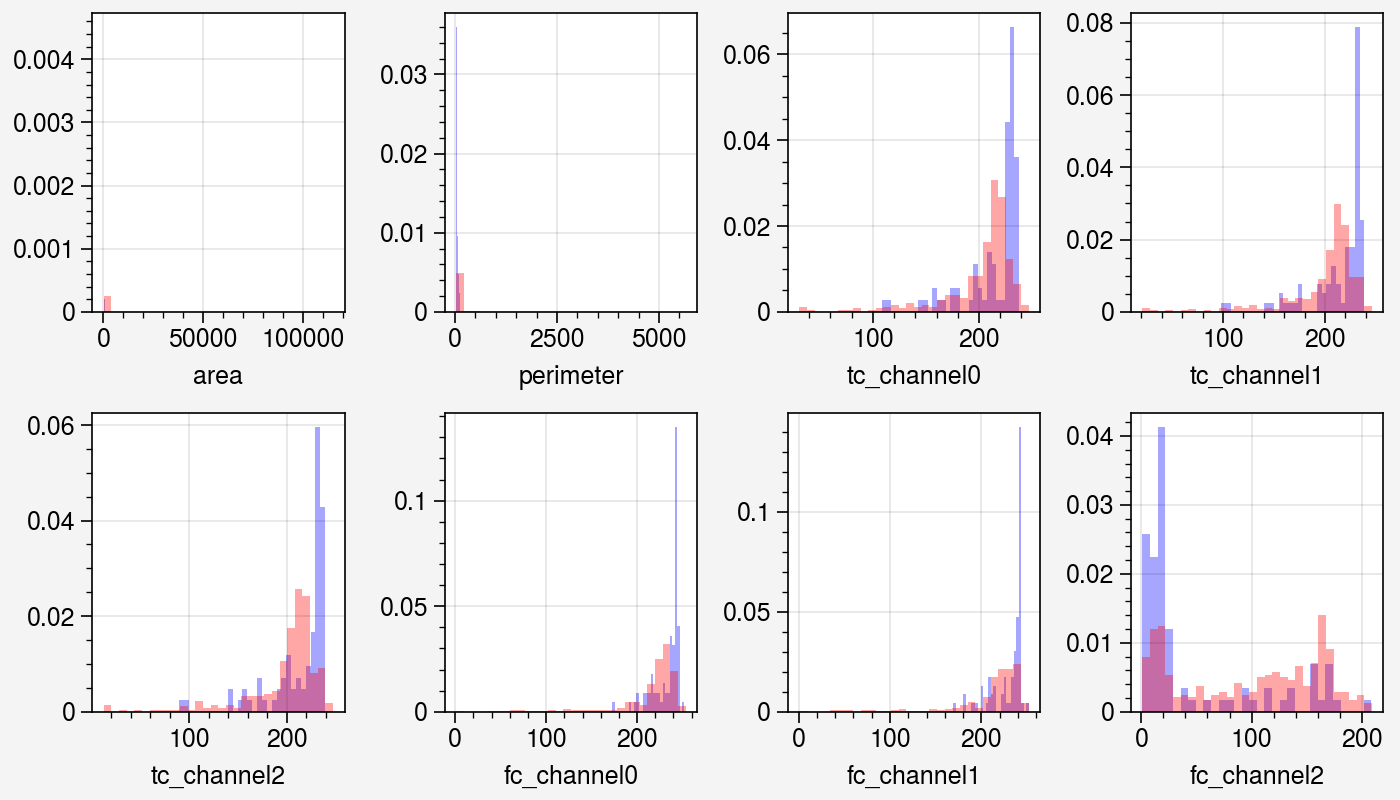

In [39]:
import proplot as pplt
fig, axs = pplt.subplots(width=7, height=4, 
                        nrows=2, ncols=4, share=False)
for var, ax in zip(variables, axs):
    ax.hist(data_tp[var], bins=30, color='b', alpha=0.35, density=True)
    ax.hist(data_fp[var], bins=30, color='r', alpha=0.35, density=True)

In [48]:
data.corr().loc[variables, variables]

,circularity,solidity,tc_channel0,tc_channel1,tc_channel2,fc_channel0,fc_channel1,fc_channel2
circularity,1.000000,0.876879,0.173861,0.176240,0.173925,0.237227,0.232446,-0.200503
solidity,0.876879,1.000000,0.136765,0.140424,0.136844,0.184477,0.175688,-0.218409
tc_channel0,0.173861,0.136765,1.000000,0.996451,0.995072,0.370736,0.376725,-0.219484
tc_channel1,0.176240,0.140424,0.996451,1.000000,0.998987,0.360939,0.367409,-0.210669
tc_channel2,0.173925,0.136844,0.995072,0.998987,1.000000,0.359431,0.368330,-0.205603
fc_channel0,0.237227,0.184477,0.370736,0.360939,0.359431,1.000000,0.994124,0.104455
fc_channel1,0.232446,0.175688,0.376725,0.367409,0.368330,0.994124,1.000000,0.142414
fc_channel2,-0.200503,-0.218409,-0.219484,-0.210669,-0.205603,0.104455,0.142414,1.000000


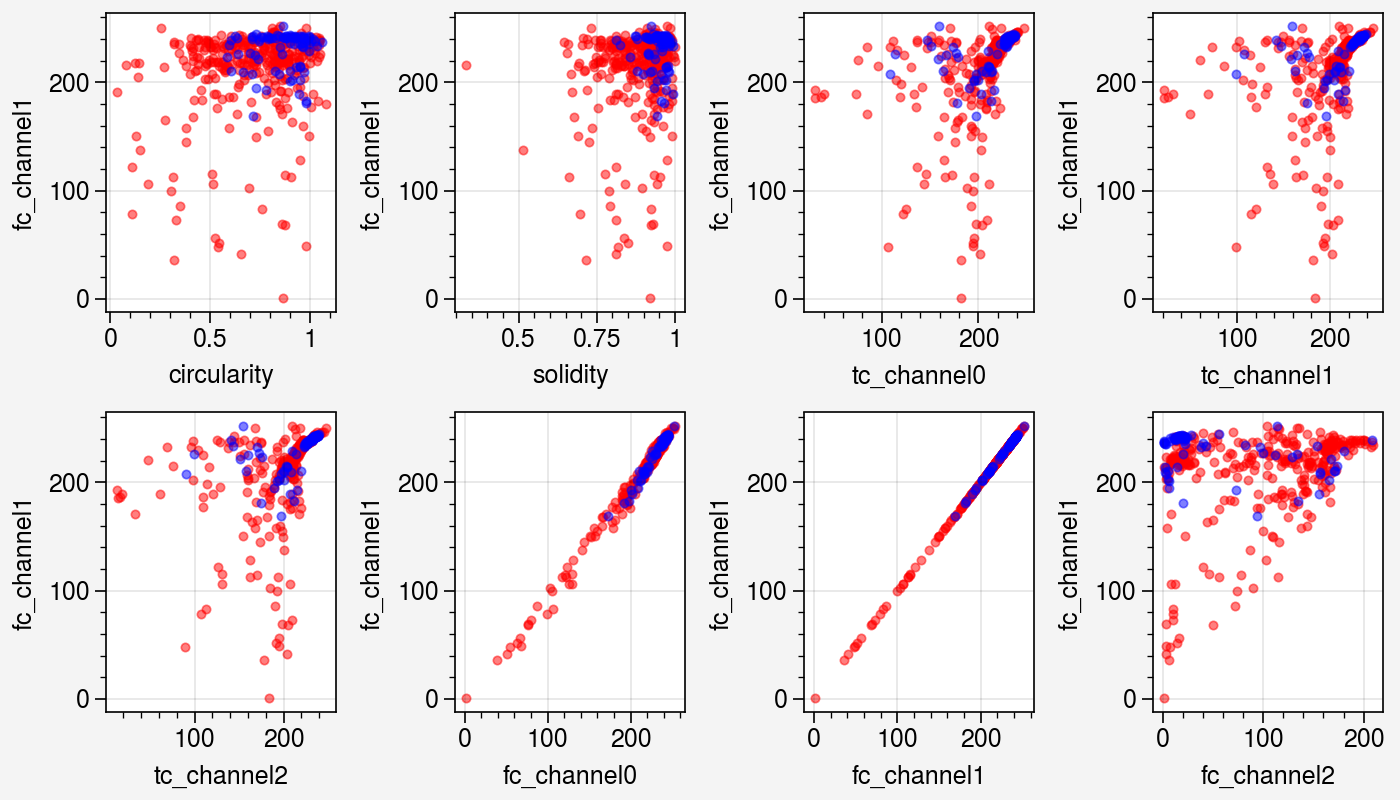

In [46]:
import proplot as pplt
fig, axs = pplt.subplots(width=7, height=4, 
                        nrows=2, ncols=4, share=False)
comp_var = 'fc_channel1'
for var, ax in zip(variables, axs):
    ax.scatter(data_fp[var], data_fp[comp_var], color='r', m='.', alpha=0.5)
    ax.scatter(data_tp[var], data_tp[comp_var], color='b', m='.', alpha=0.5)    

# Logistic regression
Logistic regression in machine learning is commonly used as a classifier. We wish to assign probabilities to candidate floes to determine if they are true positives or false positives. We use two geometric quantities - circularity and solidity - and we use the pixel brightness in the six available channels (three each from the true color and false color images). The colors are likely not independent. So there is a subset of the color channels that will be useful. E.g., FC channels 0 and 1 are 99% correlated, as are TC channels 0 and 1.

We use the implementation of logistic regression in scikit-learn (citation), an open-source machine learning library for Python. This implementation uses a regularization term. The hyperparameters . Defaults used for the regularization constants (Cs=10), we set cv to 3-fold, and we set the score using the sklearn.metrics.f1_score (can also use fbeta_score). For the solver, we use 'liblinear', as that is recommended for small datasets.

In [106]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split

In [88]:
# Scale the pixel brightness from 0 to 1
data_scaled = data.copy():
for var in variables:
    if ('tc' in var) | ('fc' in var):
        data_scaled[var] = data_scaled[var]/255
X = data_scaled.loc[:, variables].to_numpy()
y = data_scaled['TP'].to_numpy()

In [107]:
# Select 1/3 of the data for use in the testing step
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=1/3)
# Can stratify by region if eventually we get enough samples for that

In [115]:
clf = LogisticRegressionCV(Cs=10,
                     solver='liblinear',
                     scoring='f1',
                     penalty='l2',
                     cv=10,
                     random_state=5).fit(X_train, y_train)

In [116]:
data['PredictedTP'] = clf.predict(X)

In [117]:
clf.score(X_test, y_test)

0.4390243902439025

In [118]:
data['ProbabilityTP'] = clf.decision_function(X)

In [119]:
from sklearn.calibration import CalibrationDisplay

/Users/dmw/miniconda3/envs/airsea/lib/python3.9/site-packages/proplot/axes/plot.py:1275: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  obj = getattr(super(), name)(*args, **kwargs)


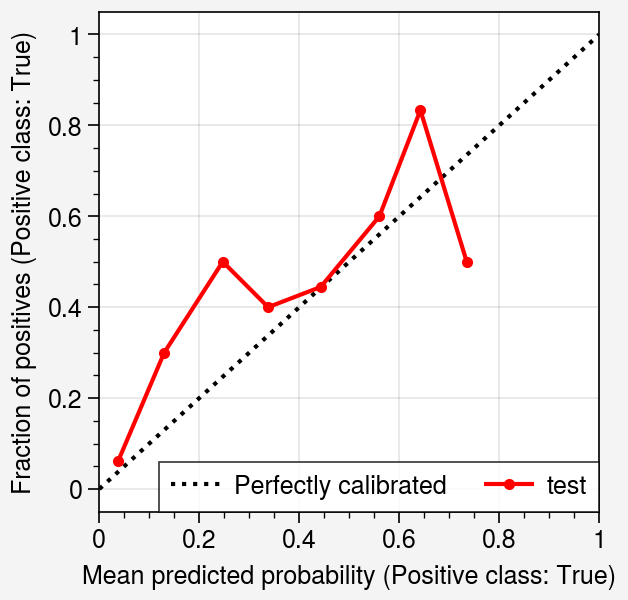

In [120]:
fig, ax = pplt.subplots()
display = CalibrationDisplay.from_estimator(
    clf,
    X_test,
    y_test,
    n_bins=10,
    name='test',
    ax=ax,
    color='r',
    marker='.',
)